# PyTorch Deep Explainer MNIST example

A simple example showing how to explain an MNIST CNN trained using PyTorch with Deep Explainer.

In [11]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap


from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [12]:
# TAMAÑO DE LAS IMÁGENES
IMG_SIZE = (256, 256)

# DIMENSIÓN DE LA CAPA DE TEMPLATES DE LOS model_trainedS
TEMPLATE_SIZE = 256

# Se establece el número de épocas
EPOCHS = 5

# Se establece el tamaño de batch
BATCH_SIZE = 32#64

# Se establece el learning rate inicial
LEARNING_RATE = 0.0005

# Directorio que contiene la base de datos sobre la que vamos a realizar el entrenamiento
MAIN_DIR ="./BD-461/Especificidad M/"

# Numero de clases a diferenciar en el clasificador
CLASES = 34

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [13]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [14]:

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, CLASES)
#modelo.fc = nn.Linear(modelo.fc.in_features, CLASES)
pesos = torch.load('./models/resnet18.pt',map_location='cuda')
model.load_state_dict(pesos)
model.to(device)
model.eval()
#model_trained.eval()

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.10.0
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
test_dataset = torchvision.datasets.ImageFolder(
    root = MAIN_DIR + "test",
    transform=test_transform
    )

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

ETIQUETAS = test_dataset.classes

In [16]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:29]
test_images = images[29:32]

e = shap.DeepExplainer(model, background.to(device))
shap_values = e.shap_values(test_images)

In [17]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


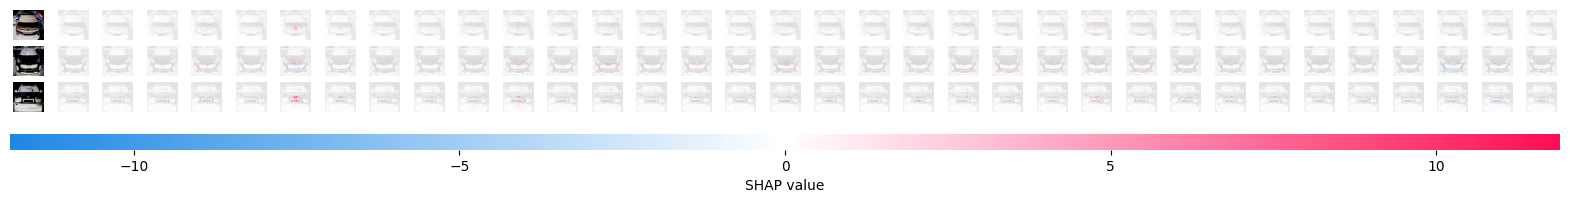

In [18]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

The plot above shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.

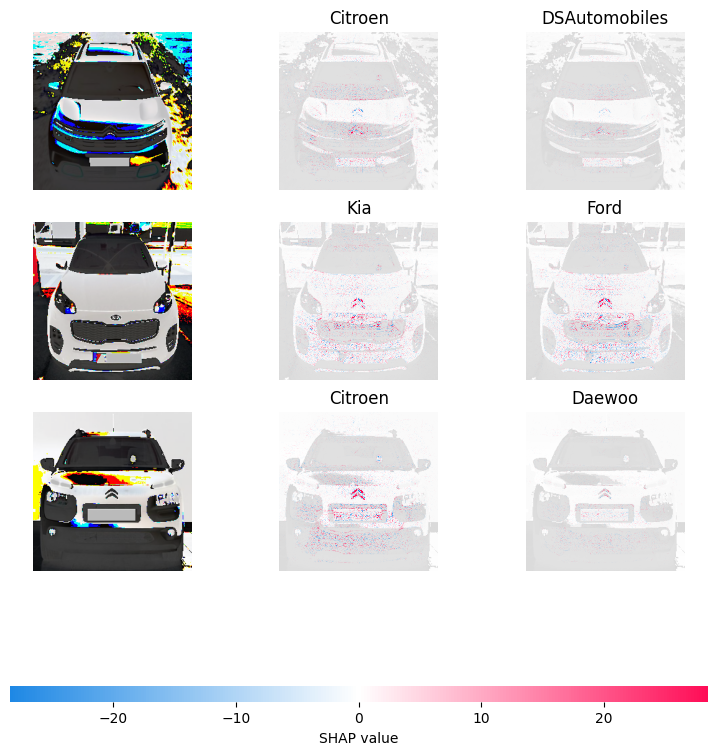

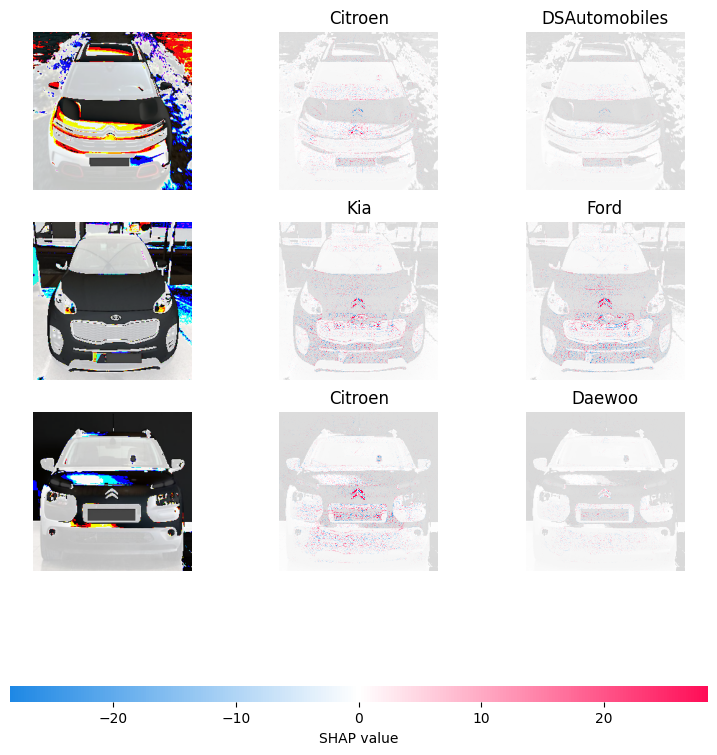

In [19]:
import shap

batch = next(iter(test_loader))
images, _ = batch

test_images = test_images.to(device)

e = shap.DeepExplainer(model, test_images)
shap_values, indexes = e.shap_values(test_images, ranked_outputs=2)
ETIQUETAS= ETIQUETAS
index_names =np.vectorize(lambda x: ETIQUETAS[x])(indexes.cpu())

shap_numpy = [np.array(s).transpose(0,2,3,1) for s in shap_values]

shap.image_plot(shap_numpy, -(test_images.cpu().numpy().transpose(0,2,3,1) * 70).astype(np.uint8), labels=index_names)

# Con test_images positivo se ve la imagen original sin invertir
#shap.image_plot(shap_numpy, (test_images.cpu().numpy().transpose(0,2,3,1) * 70).astype(np.uint8), labels=index_names)